## Analyze the combined CSV

In [1]:
# General imports
# import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, ensure_dir
from utils.df_utils import load_and_preprocess_csv, summary_histogram
from utils.visualizations import histogram, bar_graph
# from utils.model_utils import prepare_device
# # from parse_config import ConfigParser
# from data_loader import data_loaders
# import model.model as module_arch

In [15]:
# Define constants, paths
config_path = 'configs/'
# timestamp = '0112_121958' # 37 dogs
# timestamp = '0112_163516' # 128 cats
# timestamp = '0113_160154' # 1800 dogs
# timestamp = '0118_144235' # 1800 dogs w/ class dist
# timestamp = '0120_155829' # 105 cats, semantic segmentation
timestamp = '0125_114341'  # 50 cats, only felzenszwalb, semantic
# csv_path = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', timestamp, 'results_table.csv')
# csv_path = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', 'airplane_100', '0127_103716', 'results_table.csv')
csv_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/results_table.csv'
csv_path = 'saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/airplane_100/results_table.csv'
csv_path = 'saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/cat_100/results_table.csv'
print(csv_path)
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs')
ensure_dir(graph_save_dir)
class_list_path = 'metadata/cinic-10/class_names.txt'

saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/cat_100/results_table.csv


In [16]:
# Read class list
class_list = read_lists(class_list_path)
# Load CSV as pandas dataframe
# df = pd.read_csv(csv_path)
df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'],
    round_to=3)
    


n_total = len(df)
print("CSV loaded from {}".format(csv_path))
print("{} rows".format(n_total))

CSV loaded from saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/cat_100/results_table.csv
128 rows


In [17]:
# Round all numbers to 3 decimal places
mean_df = df.mean()
std_df = df.std()

# Need to remove rows with only 9 classes in predicted distribution for now
post_class_dist = df['Post Class Dist']
idxs = []
for idx, row in enumerate(post_class_dist):
    if row.shape[0] == 10:
        idxs.append(idx)
    else:
        print(idx, row)
# df = df.loc[df['Post Class Dist'].shape[0] > 0]
# print(idxs)
print("{} rows".format(len(df)))
df = df.iloc[idxs]
print("{} rows after removing incomplete class distributions".format(len(df)))

128 rows
128 rows after removing incomplete class distributions


In [18]:
def print_summary(df_, metrics=None):
    if metrics == None:
        metrics = [['{} Mean Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
                   ['{} Target Accuracy', '{} Target Precision', '{} Target Recall', '{} Target F1'],
                   ['{} Orig Pred Accuracy', '{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]

    assert type(metrics) == list and type(metrics[0]) == list, "Metrics must be a 2-D list"
    
    mean_df = df_.mean()
    std_df = df_.std()
    print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
    for row in metrics:
        for metric in row:
            print("{:<30} {:<15.3f} {:.3f}({:.3f})".format(
                metric.format(""), mean_df[metric.format("Pre")],
                mean_df[metric.format("Post")], std_df[metric.format("Post")]))
        print("")
        
def print_summaries(df_list, headers, metrics=None):
    if metrics == None:
        metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
               ['{} Target Precision', '{} Target Recall', '{} Target F1'],
               ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
    assert type(metrics) == list and type(metrics[0]) == list, "Metrics must be a 2-D list"
    
    assert len(df_list) == len(headers)
    
    # Calculate means and stds
    means_list = [df_.mean() for df_ in df_list]
    mean0 = means_list[0]
    stds_list = [df_.std() for df_ in df_list]
    
    # Form and print header
    header_string = "{:<30} {:<15}".format("Metric", "Pre-Edit")
    for header in headers:
        header_string += " {:<17}".format(header)
    print(header_string)
    
    for row in metrics:
        for metric in row:
            row_string = "{:<30} {:<15.3f}".format(
                metric.format(""), mean0[metric.format("Pre")])
            for mean, std in zip(means_list, stds_list):
                row_string += " {:.3f}({:.3f})  \t".format(
                    mean[metric.format("Post")],
                    std[metric.format("Post")])
                
            print(row_string)
        print("")
    
def get_unique_key_images(df_):
    # Obtain unique key images
    ids = list(df_['ID'])
    unique_keys = set()
    for image_id in ids:
        key_id = image_id.split('/')[0]
        unique_keys.add(key_id)
    return unique_keys

def orig_pred_histogram(df_,
                        class_list,
                        metrics=None,
                        n_bins=10,
                        save_dir=None):
    
    if metrics is None:
        metrics = ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']
    
    # Get unique class idxs
    unique_orig_classes = set(df['Pre key Prediction'].to_numpy())

    for class_idx in unique_orig_classes:
        for metric in orig_pred_metrics:
            # pre_metric = df[metric.format("Pre")].to_numpy()
            if save_dir is not None:
                save_path = os.path.join(save_dir, class_list[class_idx], metric.format("").strip())
            else:
                save_path = None
            
            # Only look at subset where original class prediction is current class
            marker = df.loc[df["Pre key Prediction"] == class_idx, metric.format("Pre")].mean()
            data = df.loc[df["Pre key Prediction"] == class_idx, metric.format("Post")]
            histogram(
                data=data,
                n_bins=n_bins,
                title=metric.format("Post") + " ({})".format(class_list[class_idx]),
                xlabel=metric.split(" ", maxsplit=1)[1],
                ylabel="Counts",
                marker=marker,
                save_path=save_path
            )

def stratify_histogram(df_,
                       column_name,
                       class_list=None,
                       metrics=None,
                       n_bins=10,
                       save_dir=None):
    
    assert column_name in df_
    if metrics is None:
        metrics = ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']
    
    # Get unique class idxs
    unique_values = set(df[column_name].to_numpy())
    if len(unique_values) > 25:
        print("Warning... {} unique values. That's a lot!".format(len(unique_values)))

    for unique_value in unique_values:
        # Create unique ID for this value
        try:
            unique_id = class_list[unique_value]
        except:
            unique_id = unique_value
        
        # Iterate through metrics and make histogram for each
        for metric in orig_pred_metrics:
            if save_dir is not None:                
                save_path = os.path.join(save_dir, unique_id, metric.format("").strip())
            else:
                save_path = None
            
            # Only look at subset where original class prediction is current class
            marker = df.loc[df[column_name] == unique_value, metric.format("Pre")].mean()
            data = df.loc[df[column_name] == unique_value, metric.format("Post")]
            histogram(
                data=data,
                n_bins=n_bins,
                title=metric.format("Post") + " ({})".format(unique_id),
                xlabel=metric.split(" ", maxsplit=1)[1],
                ylabel="Counts",
                marker=marker,
                save_path=save_path
            )

def class_distribution_bar_graph(df_, 
                                 class_list, 
                                 columns=None,
                                 title=None,
                                 save_path=None):
    if columns is None:
        columns = ['Pre Class Dist', 'Post Class Dist']
    if title is None:
        title = 'Class Distribution'
    data = []
    for column in columns:
        column_data = np.array(list(df_[column]))
        mean_column_data = np.mean(column_data, axis=0)
        data.append(mean_column_data)
    data = np.stack(data, axis=0)
    
    print(data)
    
    bar_graph(
        data=data,
        labels=class_list,
        groups=columns,
        title=title,
        xlabel_rotation=30,
        ylabel='Counts',
        save_path=save_path)
    
    
def mean_numpy_series(series, axis=0):
    '''
    Given a series of numpy arrays, return the mean

    Arg(s):
        series : pd.Series
            series to take mean of
        axis : int
            axis across which to take the mean. Default is 0

    '''
    data = np.array(list(series))
    return np.mean(data, axis=axis)

## Print summaries

Metric                         Pre-Edit        Post-Edit           
 Mean Accuracy                 0.687           0.666(0.025)
 Mean Precision                0.692           0.725(0.028)
 Mean Recall                   0.687           0.666(0.025)
 Mean F1                       0.684           0.673(0.015)

 Target Accuracy               0.911           0.832(0.063)
 Target Precision              0.554           0.374(0.086)
 Target Recall                 0.549           0.737(0.094)
 Target F1                     0.551           0.482(0.056)

[[ 9027.         7272.         8762.         6940.         7113.
   4234.         7609.         6389.         6177.         6477.       ]
 [ 8247.1171875  7182.328125   7132.8671875 15049.4296875  5748.1640625
   2987.875      6378.8203125  5746.375      5712.453125   5814.5703125]]


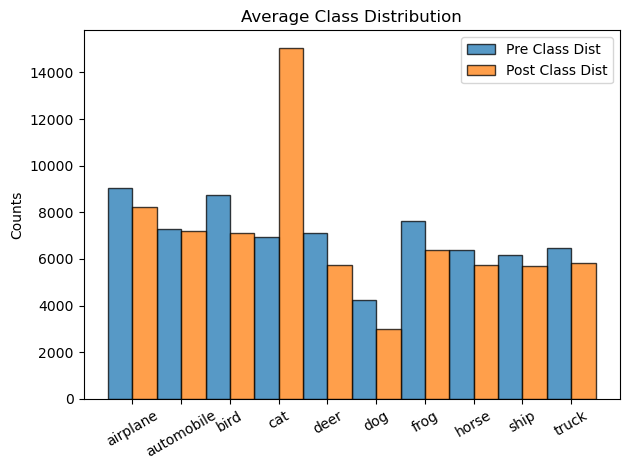

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


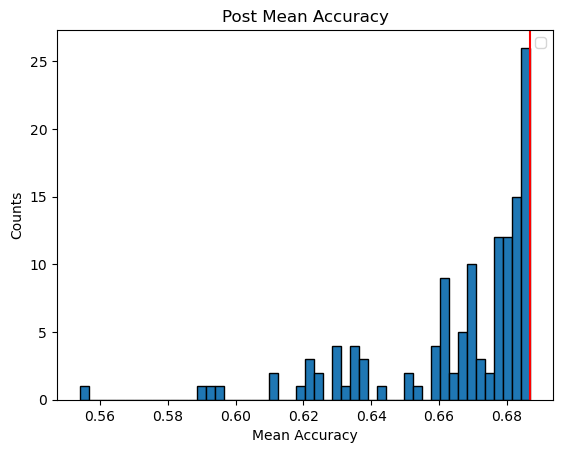

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


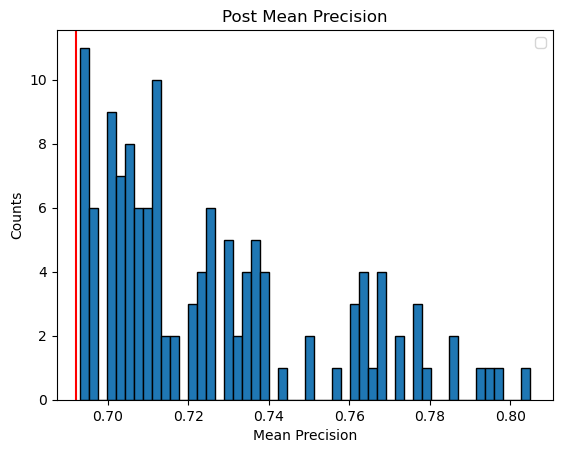

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


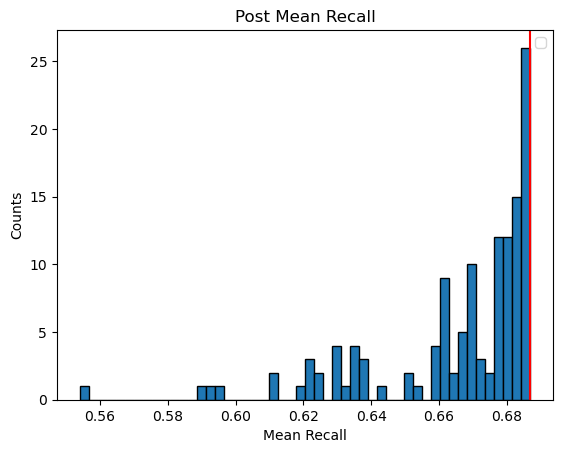

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


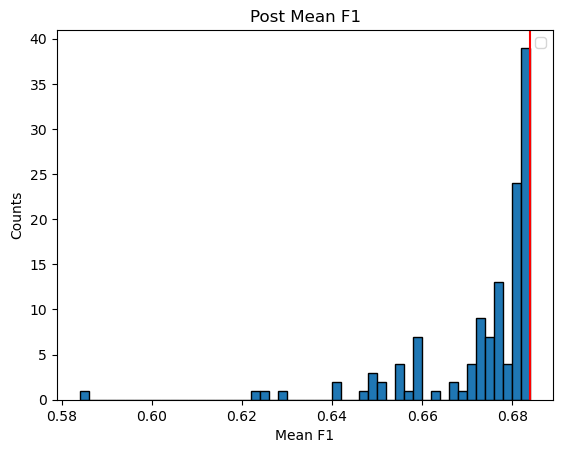

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


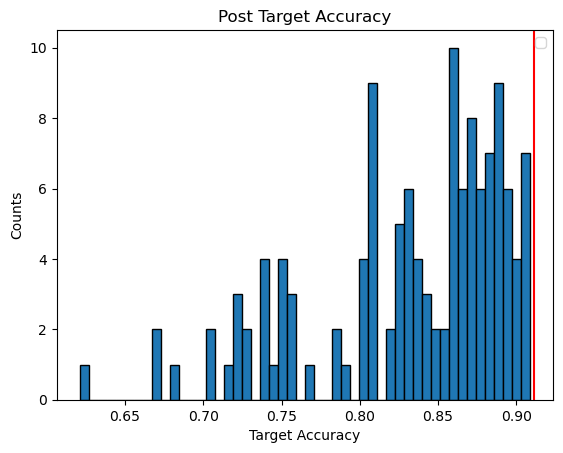

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


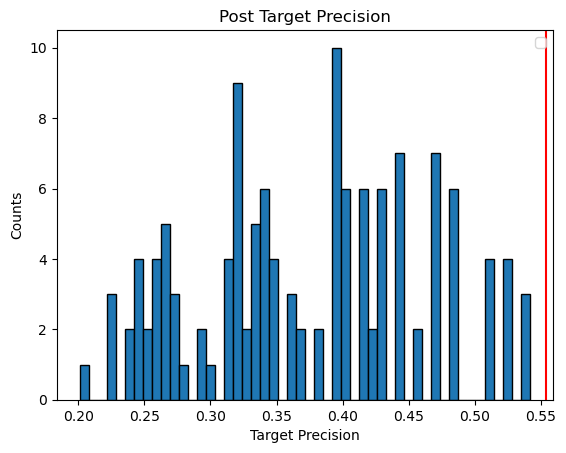

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


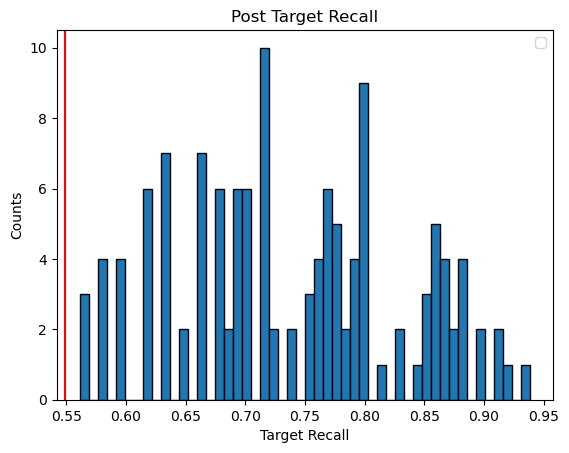

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


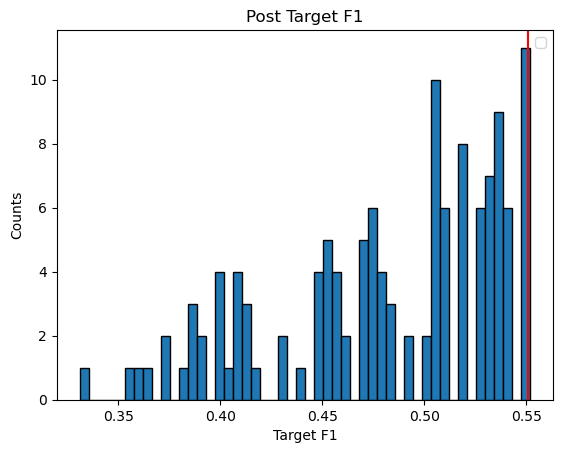

<Figure size 640x480 with 0 Axes>

In [19]:
if 'bump' in csv_path:
    metrics = [['{} Mean Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
       ['{} Target Accuracy', '{} Target Precision', '{} Target Recall', '{} Target F1']]
elif 'noise' in csv_path:
    metrics = [['{} Mean Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1']]
else:
    metrics = [['{} Mean Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
       ['{} Target Accuracy', '{} Target Precision', '{} Target Recall', '{} Target F1'],
       ['{} Orig Pred Accuracy', '{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
# Print overall summary
print_summary(df, metrics=metrics)
summary_save_dir = os.path.join(graph_save_dir, 'summary')
ensure_dir(summary_save_dir)
# Display bar graph of class distributions
class_distribution_bar_graph(df,
     class_list=class_list,
     columns=['Pre Class Dist', 'Post Class Dist'],
     title="Average Class Distribution",
     save_path=os.path.join(summary_save_dir, 'class_dist.png'))
# Display histogram of overall


summary_histogram(df,
              metrics=metrics,
              n_bins=50,
              save_dir=summary_save_dir)



In [ ]:
# Display histograms per original class prediction
orig_pred_metrics = ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']
orig_pred_save_dir = os.path.join(graph_save_dir, 'original_predictions')
stratify_histogram(df,
                   column_name="Pre key Prediction",
                   class_list=class_list,
                   metrics=orig_pred_metrics,
                   n_bins=25,
                   save_dir=orig_pred_save_dir)

## Hypothesis 1: Masked modifications will have greater changes than noise

In [ ]:
masked_rows = df[df['ID'].str.contains('masked')]
n_masked = len(masked_rows)

gaussian_rows = df[df['ID'].str.contains('gaussian')]
n_gaussian = len(gaussian_rows)
# Compare mean post edit accuracy, precision, recall, and f1
mean_masked = masked_rows.mean()
mean_gaussian = gaussian_rows.mean()
std_masked = masked_rows.std()
std_gaussian = gaussian_rows.std()
# print(mean_masked)

metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
print("{:<30} {:<15} {:<20} {:<20}".format("Metric", "Pre-Edit", "Masked", "Gaussian"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
            metric.format(""), mean_masked[metric.format("Pre")],
            mean_masked[metric.format("Post")], std_masked[metric.format("Post")], "",
            mean_gaussian[metric.format("Post")], std_gaussian[metric.format("Post")]))
    print("")
    
# Bar graph comparing original / post masked / post gaussian
data = []
groups = ['Pre Edit', 'Masked Edit', 'Gaussian Edit']
data.append(mean_numpy_series(df['Pre Class Dist']))
data.append(mean_numpy_series(masked_rows['Post Class Dist']))
data.append(mean_numpy_series(gaussian_rows['Post Class Dist']))

data = np.stack(data, axis=0)
bar_graph(
        data=data,
        labels=class_list,
        groups=groups,
        title='Masked v Gaussian',
        xlabel_rotation=30,
        ylabel='Counts',
        save_path=os.path.join(graph_save_dir, 'class_dist_masked_gaussian.png'))
# class_distribution_bar_graph(masked_rows, 
#                              class_list=class_list, 
#                              title="Masked Class Distributions")

# class_distribution_bar_graph(gaussian_rows, 
#                              class_list=class_list, 
#                              title="Gaussian Class Distributions")

### Hypothesis 2: How many edits actually improved all three metrics for target class?

Will these also incur larger harm in overall metrics?

In [ ]:
improve_target_rows = df[
    (df['Post Target Precision'] > df['Pre Target Precision']) &
    (df['Post Target Recall'] > df ['Pre Target Recall']) & 
    (df['Post Target F1'] > df['Pre Target F1'])]      

improve_target_recall = df[df['Post Target Recall'] > df ['Pre Target Recall']] 
improve_target_f1 = df[df['Post Target F1'] > df ['Pre Target F1']] 
improve_target_precision = df[df['Post Target Precision'] > df ['Pre Target Precision']] 
    
improve_target_precision_f1 = pd.merge(improve_target_precision, improve_target_f1, how='inner', on=['ID'])
improve_target_recall_f1 = pd.merge(improve_target_recall, improve_target_f1, how='inner', on=['ID'])
improve_target_recall_and_precision = pd.merge(improve_target_recall, improve_target_precision, how='inner', on=['ID'])

print("{} edits improved all target metrics (P/R/F1) ".format(len(improve_target_rows)))
print("{} edits improved target recall".format(len(improve_target_recall)))
print("{} edits improved target F1".format(len(improve_target_f1)))
print("{} edits improved target precision".format(len(improve_target_precision)))
print("{} edits improved target precision + f1".format(len(improve_target_precision_f1)))
print("{} edits improved target recall + f1".format(len(improve_target_recall_f1)))
print("{} edits improved target precision + recall".format(len(improve_target_recall_and_precision)))


## Hypothesis 3: If the edit improved the target class (let's say F1), then the metrics of the originally predicted class will be worse

In [ ]:
save_dir = os.path.join(graph_save_dir, 'hyp3_f1')
orig_metrics = ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']
improve_target_f1 = df[df['Post Target F1'] > df ['Pre Target F1']] 
mean_improve_target_f1 = improve_target_f1.mean()
std_improve_target_f1 = improve_target_f1.std()

print("Average mean metrics in original predicted class for rows that improved f1 in target class ({} samples)".format(len(improve_target_f1)))
print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
for metric in orig_metrics:
    print("{:<30} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
        metric.format(""), 
        mean_improve_target_f1[metric.format("Pre")], 
        std_improve_target_f1[metric.format("Pre")], 
        "",
        mean_improve_target_f1[metric.format("Post")],
        std_improve_target_f1[metric.format("Post")]))
    
    
# summary_histogram(
#     improve_target_f1,
#     metrics=[orig_metrics],
#     save_dir=save_dir,
#     tag='improve_target_f1')

# did not improve target f1 rows
not_improve_target_f1 = df[~df.isin(improve_target_f1)].dropna()
mean_not_improve_target_f1 = not_improve_target_f1.mean()
std_not_improve_target_f1 = not_improve_target_f1.std()

print("Average mean metrics in original predicted class for rows that did NOT improve f1 in target class({} samples)".format(len(not_improve_target_f1)))
print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
for metric in orig_metrics:
    print("{:<30} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
        metric.format(""), 
        mean_not_improve_target_f1[metric.format("Pre")], 
        std_not_improve_target_f1[metric.format("Pre")], 
        "",
        mean_not_improve_target_f1[metric.format("Post")],
        std_not_improve_target_f1[metric.format("Post")]))
# summary_histogram(
#     not_improve_target_f1,
#     metrics=[orig_metrics],
#     save_dir=save_dir,
#     tag='not_improve_target_f1')

# Graph histogram of improved target f1 and did not improve target f1 on original predicted class metrics together
labels = ['Improved Target F1', 'Did NOT Improve Target F1']
for metric in orig_metrics:
    save_path = os.path.join(save_dir, metric.format("").strip())
    data = []
    data.append(improve_target_f1[metric.format("Post")])
    data.append(not_improve_target_f1[metric.format("Post")])   
    marker = mean_improve_target_f1[metric.format("Pre")]
    histogram(
        data=data,
        marker=marker,
        xlabel=metric.format(""),
        ylabel='Counts',
        title='{} between improved target f1 and not improved target f1'.format(metric.format("")),
        labels=labels,
        save_path=save_path)

# Bar graph of post edit class distributions
data = []
groups = ['Pre Edit', 'Improved Target F1', 'Did Not Improved Target F1']
data.append(mean_numpy_series(df['Pre Class Dist']))
data.append(mean_numpy_series(improve_target_f1['Post Class Dist']))
data.append(mean_numpy_series(not_improve_target_f1['Post Class Dist']))

data = np.stack(data, axis=0)
bar_graph(
        data=data,
        labels=class_list,
        groups=groups,
        title='Class Distribution of Improve Target F1 and Not',
        xlabel_rotation=30,
        ylabel='Counts',
        save_path=os.path.join(save_dir, 'class_dist.png'))

In [ ]:
metric_name = 'Recall'
pos_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

pos_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])] 

neg_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] < df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

neg_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] < df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])]  


In [ ]:
print("Metric: {}".format(metric_name))
print("Pos Target Pos Orig: {}".format(len(pos_target_pos_orig)))
print("Pos Target Neg Orig: {}".format(len(pos_target_neg_orig)))
print("Neg Target Pos Orig: {}".format(len(neg_target_pos_orig)))
print("Neg Target Neg Orig: {}".format(len(neg_target_neg_orig)))

## Hypothesis 4: If a gaussian noise segment is producing sucessful change, will the masked segment as well? In those cases, do the masked ones or noised ones perform better?

Result: not necessarily

In [ ]:
# Count number of rows that are gaussian noise and are masked
masked_rows = df[df['ID'].str.contains('masked')]
n_masked = len(masked_rows)

gaussian_rows = df[df['ID'].str.contains('gaussian')]
n_gaussian = len(gaussian_rows)
print("{} masked modifications\n{} Gaussian modifications".format(n_masked, n_gaussian))

# For gaussian rows, are their corresponding masked segment also there?
gaussian_IDs = gaussian_rows['ID']
corresponding_masked_IDs = gaussian_IDs.replace('gaussian', 'masked', regex=True)
# print(corresponding_masked_IDs)

masked_IDs_with_both_gaussian_and_masked = list(set(corresponding_masked_IDs) & set(df['ID']))
gaussian_IDs_with_both_gaussian_and_masked = [s.replace('masked', 'gaussian') for s in masked_IDs_with_both_gaussian_and_masked]
n_both = len(masked_IDs_with_both_gaussian_and_masked)
print("{}/{} gaussian modifications have corresponding masked segment as success:".format(n_both, n_gaussian))

print("\nOf data with both masked and gaussian modifications producing changed prediction:")

masked_rows = df.loc[df['ID'].isin(masked_IDs_with_both_gaussian_and_masked)]
print("Masked results ({} rows):".format(len(masked_rows)))
print_summary(masked_rows)

gaussian_rows = df.loc[df['ID'].isin(gaussian_IDs_with_both_gaussian_and_masked)]
print("Gaussian results ({} rows):".format(len(gaussian_rows)))

print_summary(gaussian_rows)


## Hypothesis 5: Smaller segments will produce smaller changes


## Hypothesis 6: The neighbors of the value images should be less affected than the neighbors of the key images

Compare distance between key-keyN and val-valN before and after the edit. The difference should be smaller for val-valN

In [ ]:
# mean_diff_key_keyN = (df['Post key-keyN (F)'] - df['Pre key-keyN (F)']).mean()
mean_df = df.mean()
for data_type in ["F", "L"]:
    mean_pre_key_keyN = mean_df['Pre key-keyN ({})'.format(data_type)]
    mean_post_key_keyN = mean_df['Post key-keyN ({})'.format(data_type)]
    diff_key_keyN = mean_post_key_keyN - mean_pre_key_keyN
    percent_diff_key_keyN = diff_key_keyN / mean_pre_key_keyN * 100
    k_n_increase = len(df[df['Pre key-keyN ({})'.format(data_type)] < df['Post key-keyN ({})'.format(data_type)]])
    k_n_decrease = len(df) - k_n_increase
    # mean_diff_val_valN = (df['Post val-valN (F)'] - df['Pre val-valN (F)']).mean()
    mean_pre_val_valN = mean_df['Pre val-valN ({})'.format(data_type)]
    mean_post_val_valN = mean_df['Post val-valN ({})'.format(data_type)]
    diff_val_valN = mean_post_val_valN - mean_pre_val_valN
    percent_diff_val_valN = diff_val_valN / mean_pre_val_valN * 100
    v_n_increase = len(df[df['Pre val-valN ({})'.format(data_type)] < df['Post val-valN ({})'.format(data_type)]])
    v_n_decrease = len(df) - v_n_increase

    print("{}".format("Features" if data_type == 'F' else "Logits"))
    print("\tKey -> Key Neighbors: {:.3f} ==> {:.3f}".format(mean_pre_key_keyN, mean_post_key_keyN))
    print("\t\tMean difference: {:.3f} ({:.2f}%)".format(diff_key_keyN, percent_diff_key_keyN))
    print("\t\tNum increase: {} Num decrease: {}".format(k_n_increase, k_n_decrease))
    print("\tVal -> Val Neighbors: {:.3f} ==> {:.3f}".format(mean_pre_val_valN, mean_post_val_valN))
    print("\t\tMean difference: {:.3f} ({:.2f}%)".format(diff_val_valN, percent_diff_val_valN))
    print("\t\tNum increase: {} Num decrease: {}".format(v_n_increase, v_n_decrease))
    

## Hypothesis 7: Edits that shared an original image will have smaller spread in post edit metrics


In [ ]:
# Obtain unique key images

unique_keys = get_unique_key_images(df)
print("{} unique key images".format(len(unique_keys)))

metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]


key_image_stds = pd.DataFrame()
small_spread_keys = []
for unique_key in unique_keys:
    cur_rows = df[df['ID'].str.contains(unique_key)]
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
    # print("Accuracy STD: {:.3f}".format(std_cur_rows['Post Accuracy']))
    # print("Precision STD: {:.3f}".format(std_cur_rows['Post Mean Precision']))
    # print("Recall STD: {:.3f}".format(std_cur_rows['Post Mean Recall']))
    if std_cur_rows['Post Accuracy'] < 0.04:
        small_spread_keys.append(unique_key)
    # else:
    #     print(cur_rows['Post Accuracy'])
    if len(cur_rows) > 1:
        key_image_stds = key_image_stds.append(std_cur_rows, ignore_index=True)
        

mean_key_image_stds = key_image_stds.mean()
print("{:<30} {:<15} {:<20}".format("Metric", "STD Overall", "Avg STD Grouped by Key Image"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_key_image_stds[metric.format("Post")],
            100 * mean_key_image_stds[metric.format("Post")] / std_df[metric.format("Post")]))
    print("")

# print("Average accuracy standard deviation for an image: {}".format(key_image_stds['Post Accuracy']))
# print(small_spread_keys)

## Hypothesis 8: When grouping by same key image, is there a trend to variation in post edit distances?

In [ ]:
unique_keys = get_unique_key_images(df)

metrics = [['{} key-val (F)'], 
           ['{} key-valN (F)', '{} val-keyN (F)', '{} key-keyN (F)', '{} val-valN (F)']
           ]
print("Overall distance summaries")
print_summary(df, metrics=metrics)
keys_small_dist_stds = []
small_std_rows = pd.DataFrame()
random_std_rows = pd.DataFrame()
for unique_key in unique_keys:
    # print("Distance summaries for {}".format(unique_key))
    cur_rows = df[df['ID'].str.contains(unique_key)]
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
    # print_summary(cur_rows, metrics=metrics)
    # Store this key if all its stds are < overall
    do_store = True
    for metric_row in metrics:
        for metric in metric_row:
            metric = metric.format("Post")
            if std_df[metric] < std_cur_rows[metric]:
                do_store = False
        
    if do_store:
        keys_small_dist_stds.append(unique_key)
        small_std_rows = small_std_rows.append(std_cur_rows, ignore_index=True)
        
    # Random subsets
    random_idxs = np.random.randint(len(df), size=len(cur_rows))
    random_rows = df.iloc[random_idxs]
    random_std_rows = random_std_rows.append(random_rows.std(), ignore_index=True)
    
        
mean_small_std_rows = small_std_rows.mean()
# mean_random_std_rows = random_std_rows.mean()
print("{:<30} {:<15} {:<20} {:<20}".format("Metric", "STD Overall", "Avg STD by Key", "Random subsets"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)\t    {:<15.3f}".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_small_std_rows[metric.format("Post")],
            100 * mean_small_std_rows[metric.format("Post")] / std_df[metric.format("Post")],
            mean_random_std_rows[metric.format("Post")]))
    print("")

## Hypothesis 9: Edits that share a original prediction will have more similar post edit metric results

In [ ]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]

unique_original_predictions = set(df['Pre key Prediction'])

unique_originals_stds = pd.DataFrame()
for og_prediction in unique_original_predictions:
    cur_rows = df[df['Pre key Prediction'] == og_prediction]
    if len(cur_rows) > 1:
        unique_originals_stds = unique_originals_stds.append(std_cur_rows, ignore_index=True)
    # print(len(cur_rows))
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
#     print("Original prediction: {}".format(og_prediction))
#     print("N samples: {}".format(len(cur_rows)))
#     print_summary(cur_rows)
    
mean_unique_originals_stds = unique_originals_stds.mean()
print("{:<30} {:<15} {:<20}".format("Metric", "STD Overall", "Avg STD by Orig. Pred."))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_unique_originals_stds[metric.format("Post")],
            100 * mean_unique_originals_stds[metric.format("Post")] / std_df[metric.format("Post")]))
    print("")

## Hypothesis 10: did any edits cause post edit distances to increase?

In [ ]:
metrics = [
    ['{} key-val (F)', '{} val-keyN (F)', '{} key-valN (F)', '{} key-keyN (F)', '{} val-valN (F)']
]
# Obtain for non exclusionary (may include rows where other distances increase too
for metric in metrics[0]:
    print("Metric:{}".format(metric.format("")))
    kv_f = df[df[metric.format('Post')] > df[metric.format('Pre')]]

        
    print("{} edits caused distance to increase (among others)".format(len(kv_f)))
    print_summary(kv_f)
    
    # Ensure all other metrics decrease after edit
    exc_kv_f = kv_f.copy()
    for other in metrics[0]:
        if other == metric:
            continue
        exc_kv_f = exc_kv_f[exc_kv_f[other.format("Post")] < exc_kv_f[other.format("Pre")]]
    print("{} edits caused solely {} distance to increase ".format(len(exc_kv_f), metric.format("")))
    print_summary(exc_kv_f)
    # print_summaries(
    #     df_list=[kv_f, exc_kv_f],
    #     headers=["Inclusive ({})".format(len(kv_f)), "Exclusive ({})".format(len(exc_kv_f))])
                             

## Hypothesis 11: How do the edits that improve recall of both target and original class differ from those that only improve target class (and decrease original class recall)?

In [ ]:
metric_name = 'F1'
pos_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

pos_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])] 



In [ ]:
print("Increase target and orig. prediction")
print_summary(pos_target_pos_orig)

    
# get_unique(pos_target_pos_orig)

print("Increase target and decrease orig. prediction")
print_summary(pos_target_neg_orig)
# get_unique(pos_target_neg_orig)

# Print how many neighbors became target
keys = [
    "Num of key's Neighbors Became Target (F)", 
    # "Num of key's Neighbors Unaffected (F)", 
    "Num of key's Neighbors Became Target (L)",
    # "Num of key's Neighbors Unaffected (L)", 
    "Num of val's Neighbors Became Target (F)", 
    # "Num of val's Neighbors Unaffected (F)", 
    "Num of val's Neighbors Became Target (L)",
    # "Num of val's Neighbors Unaffected (L)", 
]
key_abbr = [
    "Key features", "Key logits", "Val features", "Val logits"
]
print("Pos Target Pos Orig ({}):".format(len(pos_target_pos_orig)))
for key, abbr in zip(keys, key_abbr):
    pp_key = pos_target_pos_orig[key]
    # print("Key: {}".format(key))
    print("{} \tmean: {:.3f} median: {}".format(abbr, pp_key.mean(), pp_key.median()))
    # print(pp_key)
    
print("Pos Target Neg Orig ({}):".format(len(pos_target_neg_orig)))
for key, abbr in zip(keys, key_abbr):
    pn_key = pos_target_neg_orig[key]
    print("{} \tmean: {:.3f} median: {}".format(abbr, pn_key.mean(), pn_key.median()))
    # print(pn_key)

## Hypothesis 12: Given the changes in neighbor predictions, will we be able to see patterns in performance? 

In [ ]:
thirds = [(0, 33), (34,66), (67, 100)]
quarters = [(0, 25), (26, 50), (51, 75), (76, 100)]
for (low, high) in thirds:
    cur_third = df[((df["Num of key's Neighbors Became Target (F)"] >= low) &
                    (df["Num of key's Neighbors Became Target (F)"] <= high))]

    print("{} edits with {}-{} of key's neighbors becoming target".format(len(cur_third), low, high))
    print_summary(cur_third)
    
for (low, high) in quarters:
    cur_third = df[((df["Num of val's Neighbors Became Target (F)"] >= low) &
                    (df["Num of val's Neighbors Became Target (F)"] <= high))]

    print("{} edits with {}-{} of val's neighbors becoming target".format(len(cur_third), low, high))
    print_summary(cur_third)


In [ ]:
x_axis = df["Num of key's Neighbors Became Target (F)"].to_numpy()
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]
# metric = "Post Mean Recall"
# metric = "Post Orig Pred Recall"

for row_idx, row in enumerate(metrics):
    fig, axs = plt.subplots(len(row), figsize=(8, 16))
    for idx, metric in enumerate(row):
        ax = axs[idx]
        metric = metric.format("Post")
        y_axis = df[metric].to_numpy()
        ax.scatter(x_axis, y_axis)
        ax.set_ylabel(metric)

    plt.savefig('temp/{}.png'.format(row_idx))
    plt.show()